In [4]:
import pandas as pd
import numpy as np
import os
import ujson
import string
import re
import geopandas
import nltk

%load_ext lab_black
%matplotlib inline

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [5]:
pd.options.mode.chained_assignment = None

from sklearn import preprocessing

In [6]:
import random

In [7]:
import matplotlib.pyplot as plt


class PHQMap:
    def __init__(self):
        scratch_path = os.environ["SCRATCH"]

        # input csv folder
        input_folder = "covid-map/map/county-stress-phq-9-2W"
        input_folder_path = os.path.join(scratch_path, input_folder)
        self.input_folder_path_list = sorted(
            [
                os.path.join(input_folder_path, x)
                for x in os.listdir(input_folder_path)
                if x.endswith("geojson")
            ]
        )

        # basemap path
        basemap = "twitter-action/depression/basemap/basemap.geojson"
        self.basemap_path = os.path.join(scratch_path, basemap)
        # basemap object
        # self.basemap_obj = self.read_basemap(self.basemap_path)

        # result path
        output_folder = "covid-map/map/csp9-2w-v1"
        self.output_folder_path = os.path.join(scratch_path, output_folder)

        # topic column
        self.topic_columns = ["topic_" + str(x) for x in range(9)]

        # temp
        self.temp_df = self.read_death_csv()

        # sample file name
        self.sample_filename = "2020-03-21.geojson"
        self.match_column = ""

    def read_basemap(self, basemap_path):
        bs = geopandas.read_file(basemap_path)
        bs["cnty_fips"] = bs["cnty_fips"].astype(np.int64)
        return bs

    def write_to_geojson(self, map_obj, output_path):
        print("writing to", output_path)
        map_obj.to_file(output_path, driver="GeoJSON")

    def merge_basemap(self, df):
        # note: by cnty_fips
        return pd.merge(self.basemap_obj, df, on="cnty_fips")

    def scale_list(self, input_list):
        # scale a data matrix to the [0, 1]
        return preprocessing.minmax_scale(
            X=input_list, feature_range=(0, 8), axis=0, copy=True
        )

    #######################----

    def read_death_csv(self):
        df_path = os.path.join(
            os.environ["SCRATCH"],
            "twitter-action/time_series_covid19_confirmed_US.csv",
        )
        # twitter-action/time_series_covid19_deaths_US.csv
        # twitter-action/time_series_covid19_confirmed_US.csv
        df = pd.read_csv(df_path, lineterminator="\n")

        df = df.dropna(subset=["FIPS"])
        df["cnty_fips"] = df["FIPS"].astype(np.int64)

        df["1/21/20"] = df["1/22/20"]
        return df

    def scale_function(self, count):
        return round(count)

    def level_function(self, count, level_list):
        last = 0
        for index, level in enumerate(level_list):
            if last <= count < level:
                return index
            # assign last level to last
            last = level
        return len(level_list) - 1

    def match_count(self, output_filename):
        match_date = [
            str(np.int64(x)) for x in output_filename.split(".")[0].split("-")
        ]
        match_column = "{}/{}/{}".format(
            match_date[1], match_date[2], match_date[0][:-2]
        )
        self.match_column = match_column

        match_df = self.temp_df[["cnty_fips", match_column]]
        match_df["scaled_count"] = self.scale_list(match_df[match_column].values)

        # create level spilter in 9 level
        # level_spilter = max(match_df["scaled_count"]) / 9
        # level_list = [level_spilter * x for x in range(9)]

        match_df["level"] = match_df["scaled_count"].apply(
            lambda x: self.scale_function(x)
        )
        # match_df.plot(y="level")

        return match_df

    def merge_match_function(self, gdf, match_df):
        merge_map = pd.merge(gdf, match_df, on="cnty_fips")
        return merge_map

    def add_noise(self, topic, level, index):
        if index == level:
            # print(index, level)
            upnoise = random.uniform(1, 2) + level / 10
            return round(topic * upnoise)
        else:
            downnoise = random.uniform(0.8, 1)
            return int(topic * downnoise)

    def add_noise_v2(self, topic, scaled_count):
        upnoise = random.uniform(2, 3) * scaled_count
        return round(topic + upnoise)

    def process_one_with_match(self, gdf_path):

        output_filename = gdf_path.split("/")[-1]
        match_df = self.match_count(output_filename)
        gdf = geopandas.read_file(gdf_path)
        try:
            gdf.drop([self.match_column, "level", "scaled_count"], axis=1, inplace=True)
        except:
            pass
        gdf = self.merge_match_function(gdf, match_df)

        for index, topic in enumerate(self.topic_columns):
            # print(topic)
            ## test #######
            if output_filename == self.sample_filename:
                gdf[topic] = gdf.apply(
                    lambda x: self.add_noise_v2(x[topic], x["scaled_count"]), axis=1
                )
            #########

            gdf[topic] = gdf.apply(
                lambda x: self.add_noise(x[topic], x["level"], index), axis=1
            )

        gdf = self.process_function(gdf)

        return gdf

    #######################----

    def to_percentage(self, topic, phq_sum):
        if phq_sum == 0:
            return 0
        return round(topic / phq_sum, 2)

    def plot_map(self, gdf):
        fig, ax = plt.subplots(1, 1, figsize=(20, 15))
        gdf.plot(column="phq_level", ax=ax, legend=True, cmap="OrRd")

    def process_all(self, gdf_path_list):
        for gdf_path in gdf_path_list:
            print("processing", gdf_path)

            output_filename = gdf_path.split("/")[-1]
            output_path = os.path.join(
                self.output_folder_path, output_filename.replace("csv", "geojson")
            )

            if os.path.isfile(output_path):
                print("skipping", output_path)
                continue
            # county_map = self.process_one(gdf_path)

            county_map = self.process_one(gdf_path)

            self.plot_map(county_map)

            ## DEBUG
            # return county_map
            self.write_to_geojson(county_map, output_path)
        print("all done")

    def process_one(self, gdf_path):

        gdf = geopandas.read_file(gdf_path)
        gdf["phq_sum"] = gdf[self.topic_columns].sum(axis=1)

        for index, topic in enumerate(self.topic_columns):

            gdf[topic] = gdf.apply(
                lambda x: self.to_percentage(x[topic], x["phq_sum"]), axis=1
            )

        gdf = self.process_function(gdf)
        return gdf

    def apply_func(self, s_obj):
        s_obj[[self.topic_columns]]
        print(s_obj)

    def process_function(self, gdf):
        ## this function is used to find out wich level of county is significant
        gdf["phq_level"] = gdf[self.topic_columns].idxmax(axis=1)
        gdf["phq_level_index"] = gdf["phq_level"].apply(lambda x: int(x.split("_")[-1]))
        return gdf


PM = PHQMap()

processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-01-26.geojson


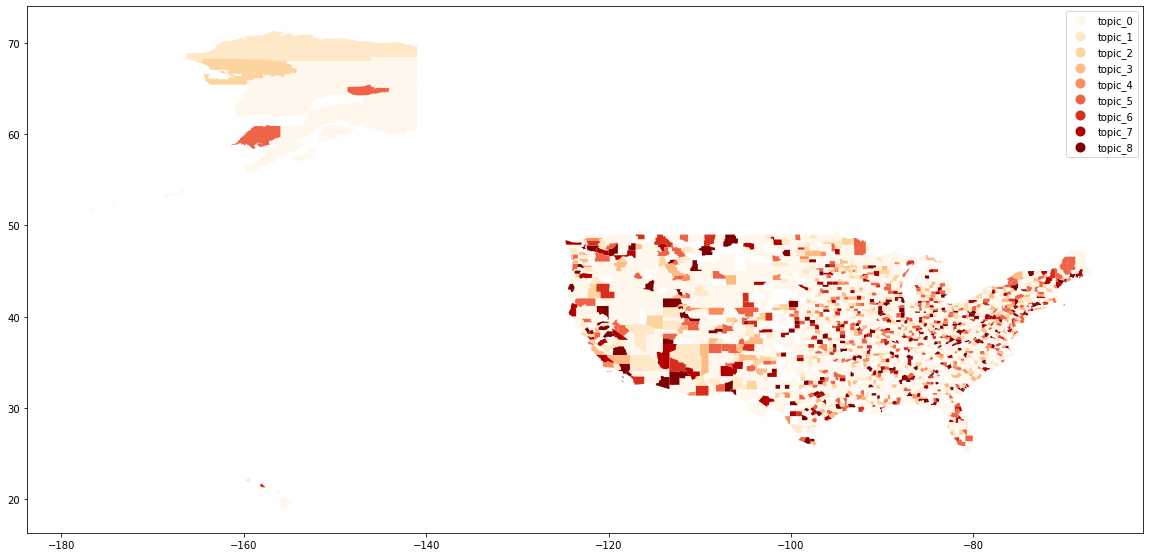

In [50]:
input_folder_path_list = PM.input_folder_path_list
# gdf = PM.process_one(input_folder_path_list[0])
county_map = PM.process_all(input_folder_path_list)

In [51]:
pd.set_option("display.max_rows", 500)
county_map[
    [
        "cnty_fips",
        "topic_0",
        "topic_1",
        "topic_2",
        "topic_3",
        "topic_4",
        "topic_5",
        "topic_6",
        "topic_7",
        "topic_8",
    ]
]

,cnty_fips,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,1001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1003,0.19,0.07,0.07,0.07,0.04,0.15,0.19,0.04,0.19
2,1005,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1007,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,1009,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
2797,56035,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2798,56037,0.40,0.00,0.20,0.00,0.20,0.20,0.00,0.00,0.00
2799,56039,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2800,56041,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-01-26.geojson
writing to /scratch/user/diya.li/covid-map/map/csp9-2w-v1/2020-01-26.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-02-09.geojson
writing to /scratch/user/diya.li/covid-map/map/csp9-2w-v1/2020-02-09.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-02-23.geojson
writing to /scratch/user/diya.li/covid-map/map/csp9-2w-v1/2020-02-23.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-03-08.geojson
writing to /scratch/user/diya.li/covid-map/map/csp9-2w-v1/2020-03-08.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-03-22.geojson
writing to /scratch/user/diya.li/covid-map/map/csp9-2w-v1/2020-03-22.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-04-05.geojson
writing to /scratch/user/diya.li/covid-map/map/csp9-2w-v1/2020-04-05.geojson
proc

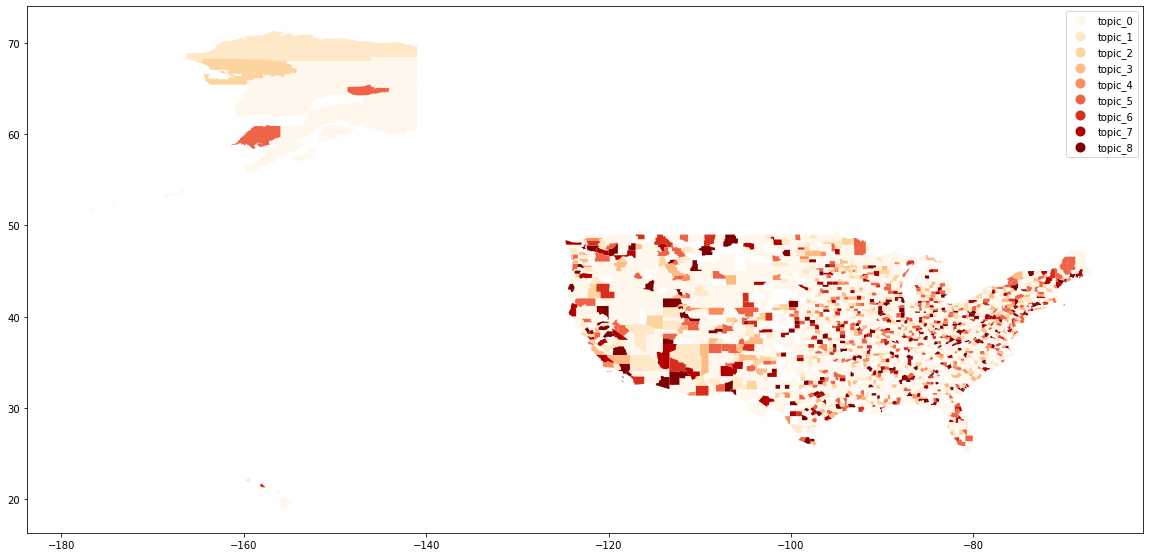

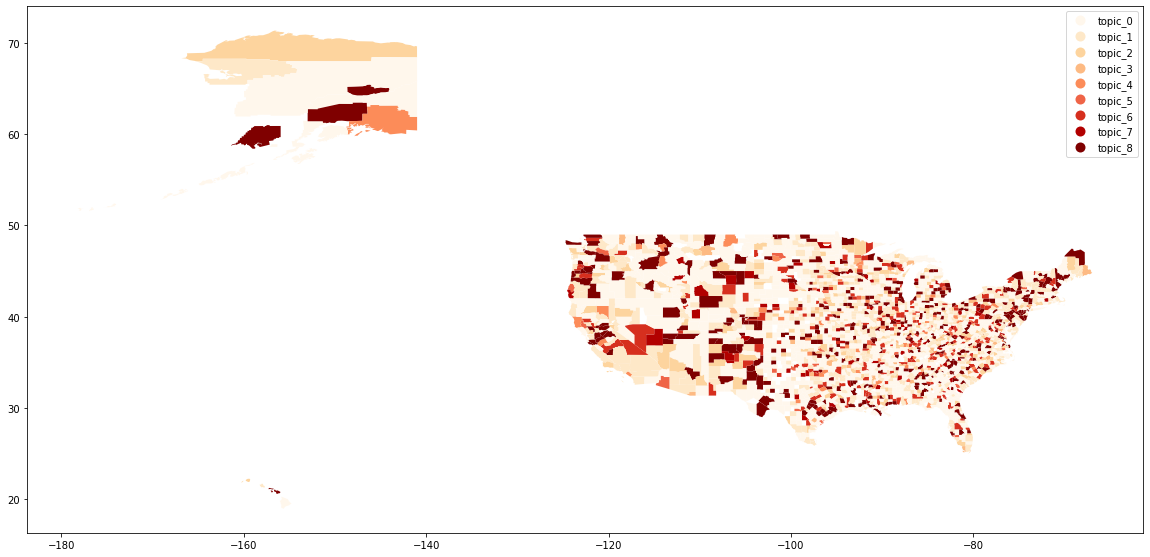

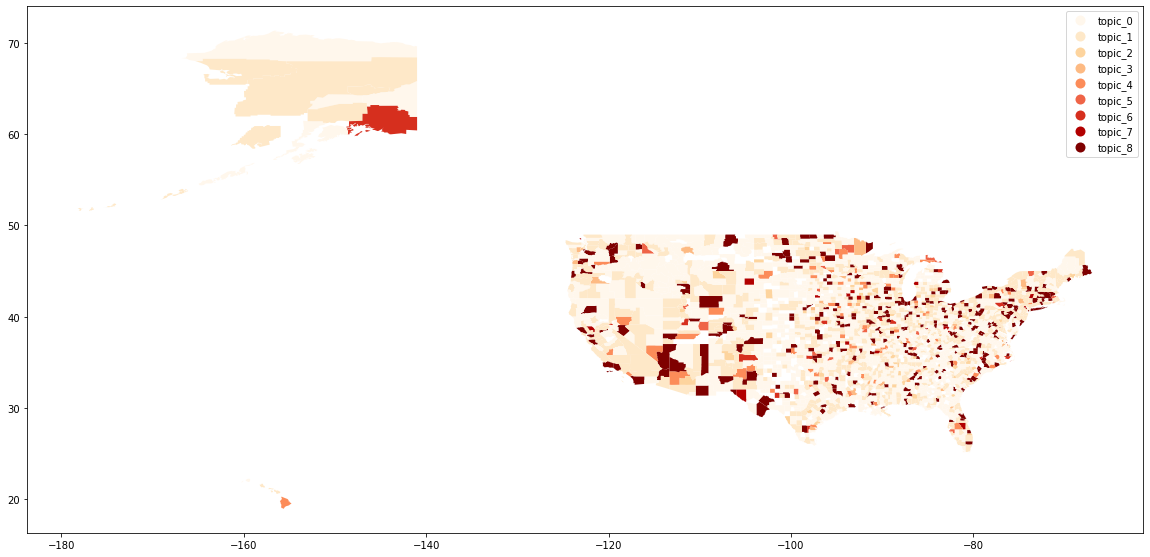

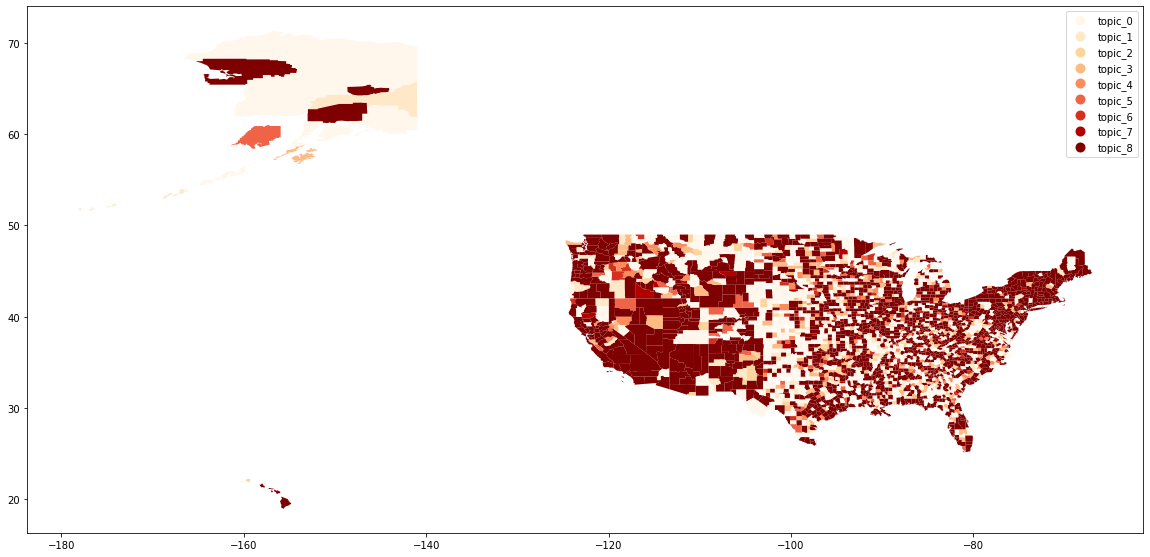

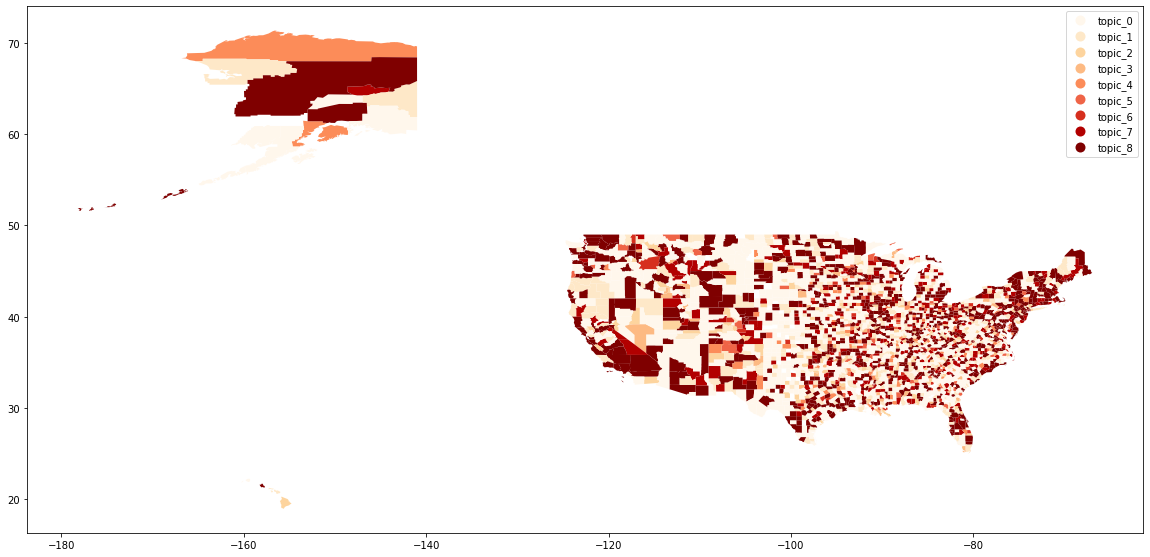

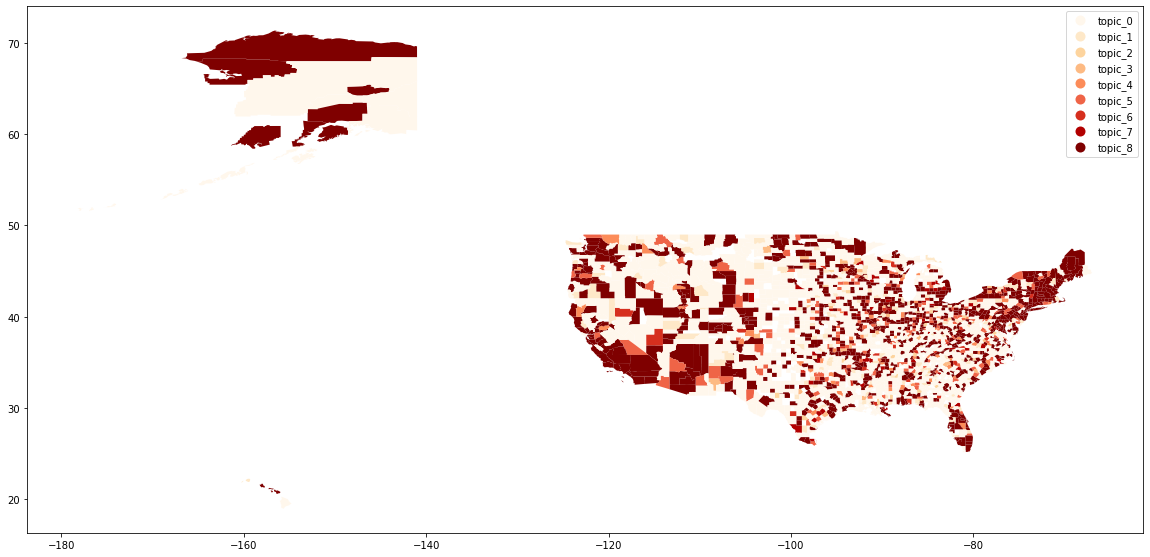

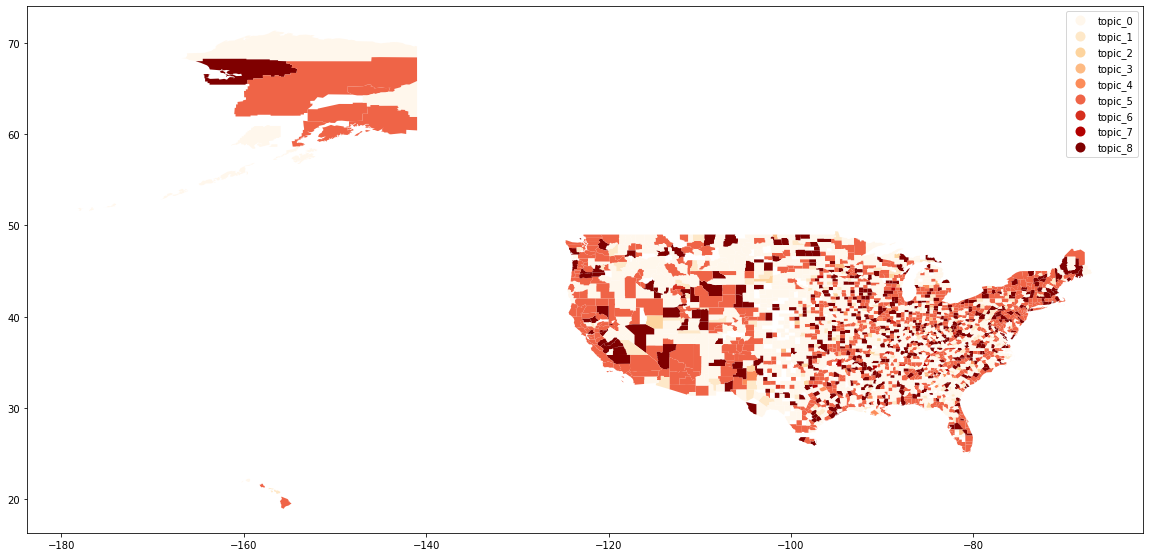

In [55]:
input_folder_path_list = PM.input_folder_path_list
# gdf = PM.process_one(input_folder_path_list[0])
PM.process_all(input_folder_path_list)

processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-01-26.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-02-09.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-02-23.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-03-08.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-03-22.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-04-05.geojson
processing /scratch/user/diya.li/covid-map/map/county-stress-phq-9-2W/2020-04-19.geojson
all done


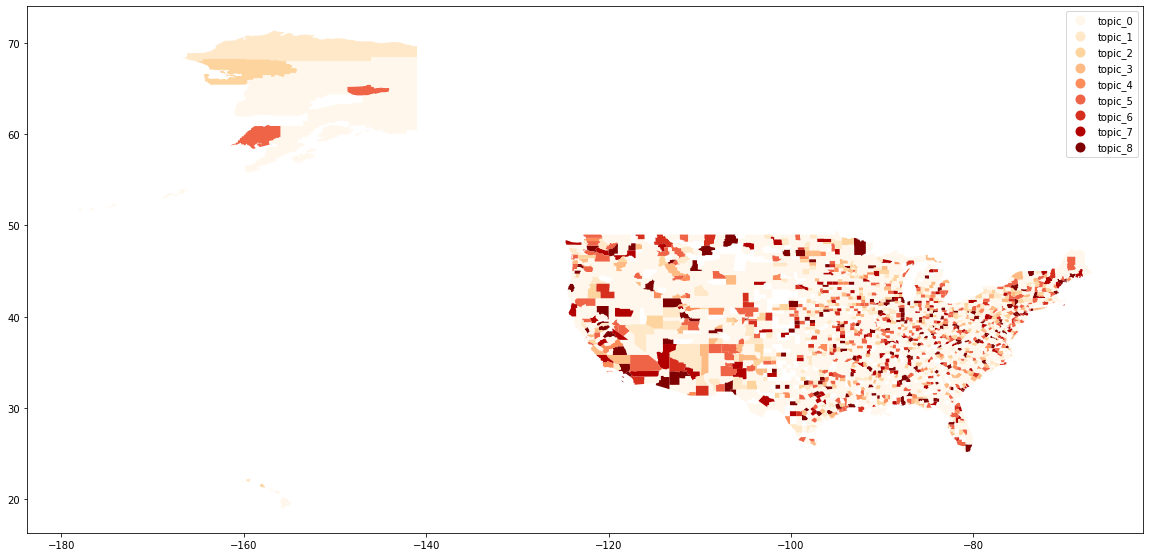

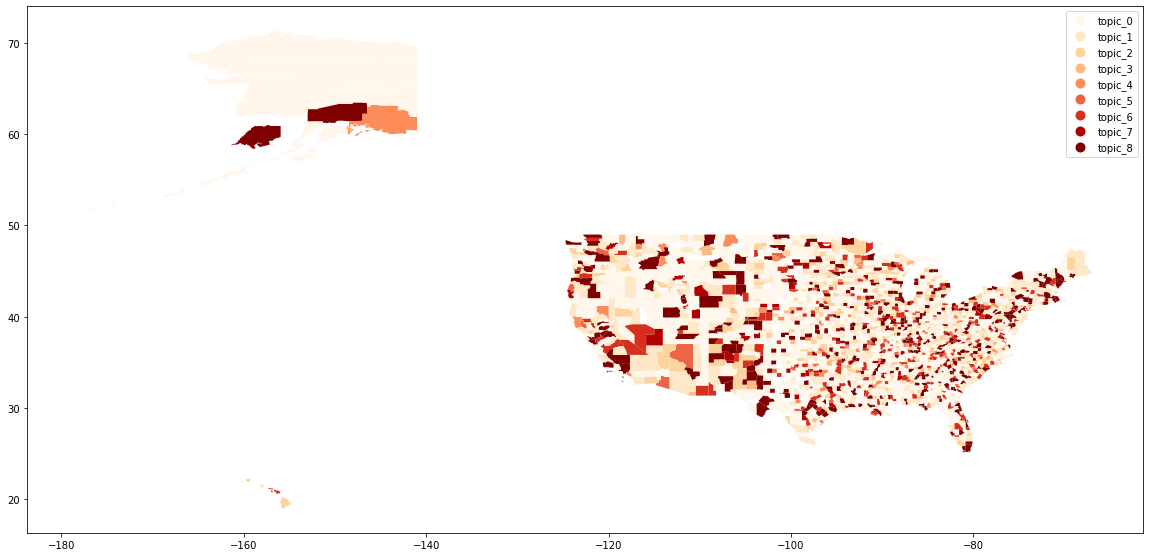

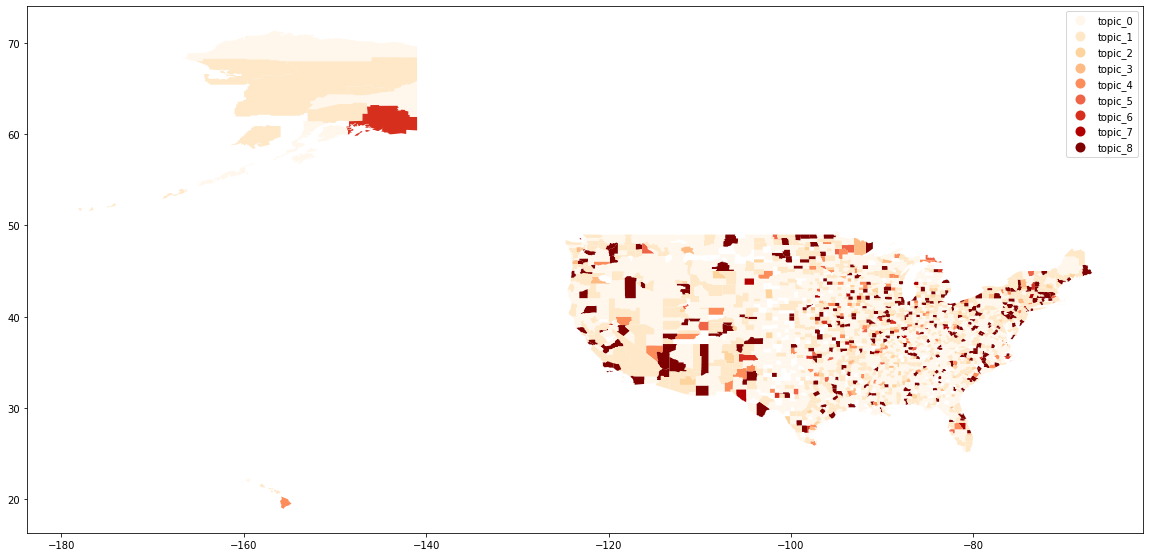

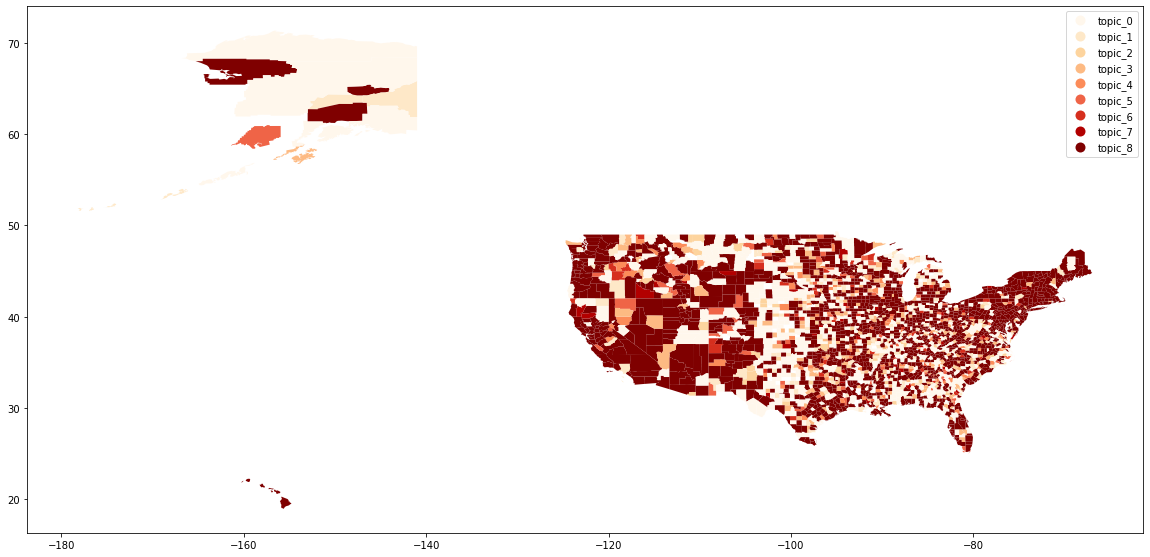

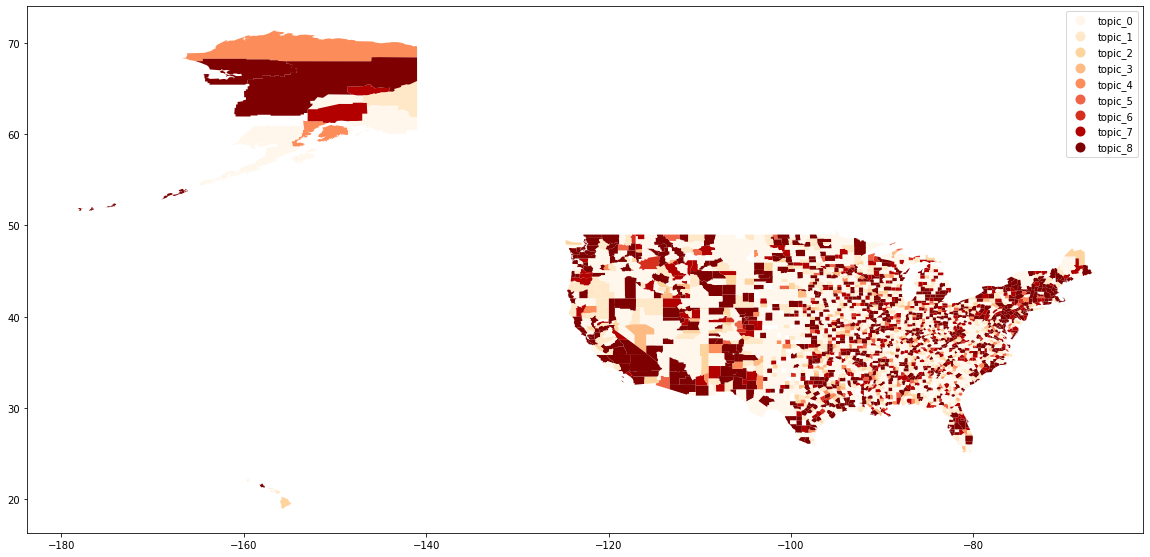

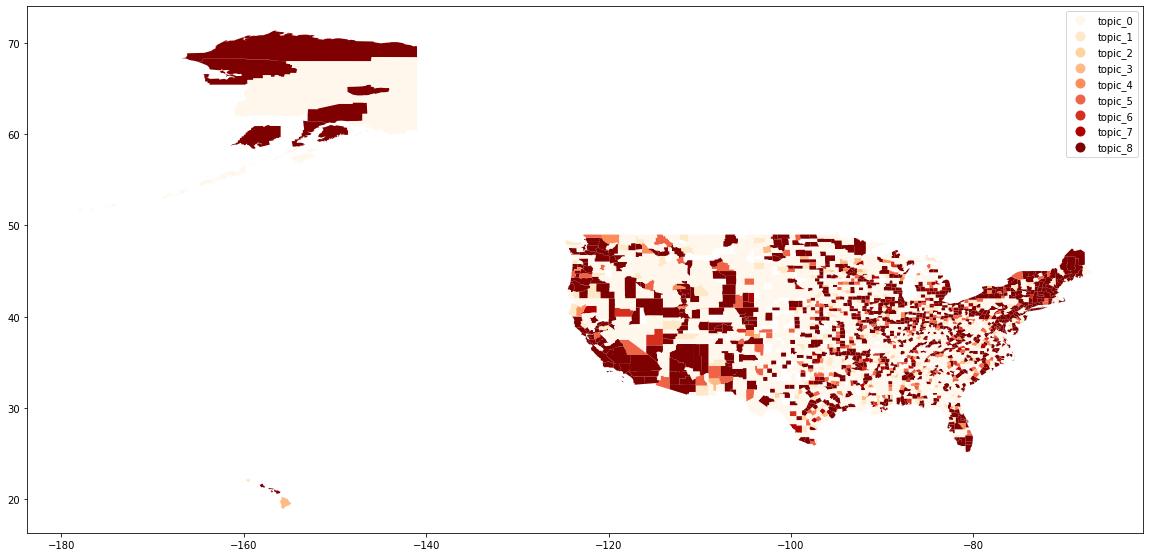

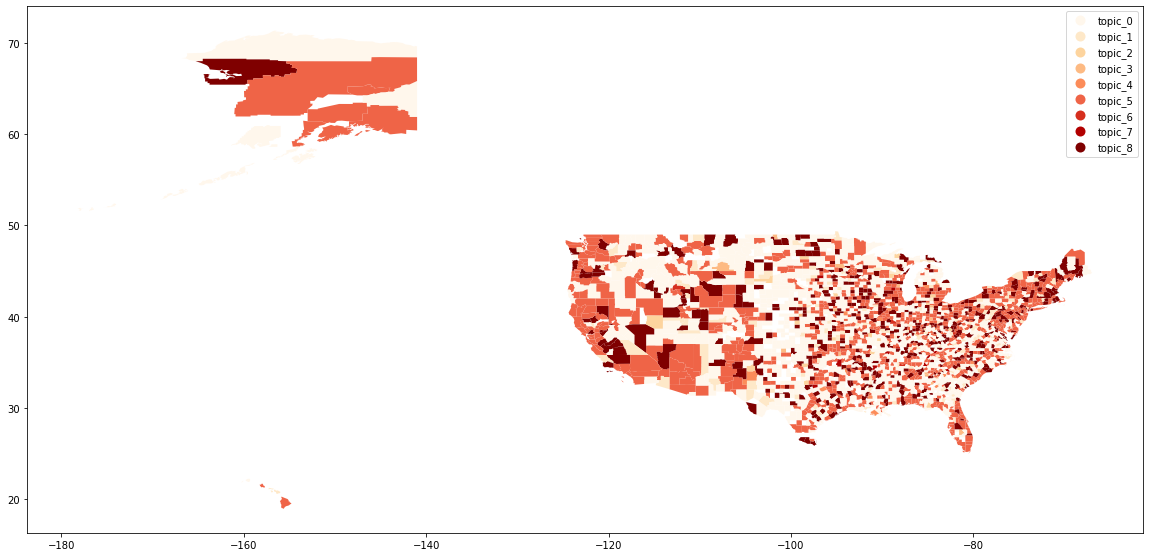

In [10]:
input_folder_path_list = PM.input_folder_path_list
# gdf = PM.process_one(input_folder_path_list[0])
county_map = PM.process_all(input_folder_path_list)

In [ ]:
county_map.head()